# Introduction to Raster Data with `rasterio`: Part 3, Introducing `rasterstats()`

### Goal: Introduce `rasterstats`!

- https://pythonhosted.org/rasterstats/


- "...exists solely to extract information from geospatial raster data based on vector geometries"


- Zonal statistics (mean, median, etc. of values intersecting a vector geometry)


- Point queries (includes interpolation, not just nearest value)

In [84]:
#Import our basic libraries

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

In [85]:
#Import our basic rasterio stuff
########

import rasterio
from rasterio.plot import show
import rasterio.mask


In [86]:
# And now the rasterstats!
#########

from rasterstats import zonal_stats, point_query

In [87]:
import warnings
warnings.filterwarnings("ignore")

### Preamble: Get State Vector Data

- Grab state vector data
- Will load rasters in a moment

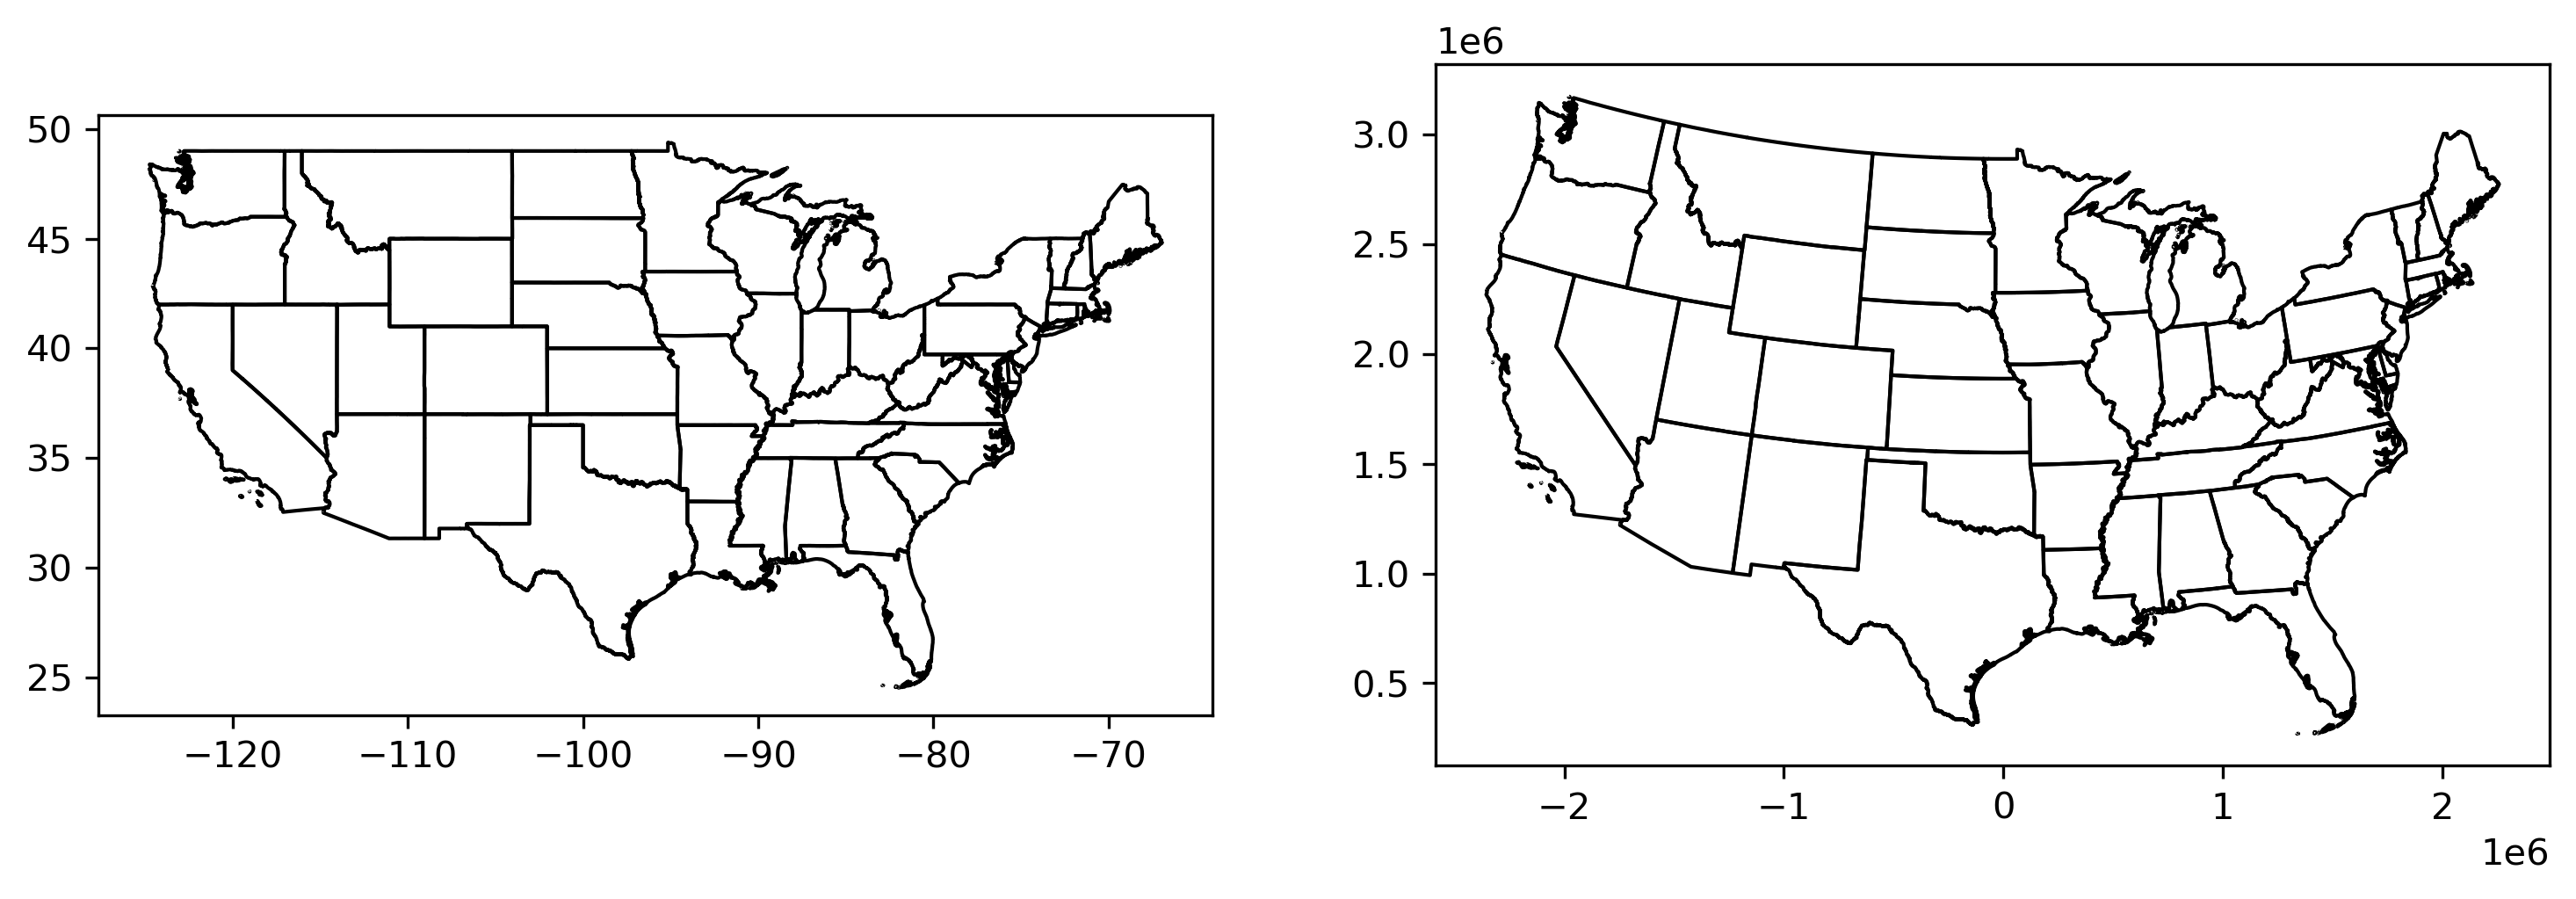

In [88]:
#Get shapefile data directly from census URLs
#########

url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
state_gdf = gpd.read_file(url_state)

#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

#Convert to EPSG 4326 to Mask WorldClim Rasters # is 5070
state_gdf = state_gdf.to_crs(4326)

#And a 5070 version (North American Albers)
state_gdf_5070 = state_gdf.to_crs(5070)


#Plot both:
fig, ax1 = plt.subplots(1,2, figsize=(12, 8), dpi=300)

state_gdf.plot(ax = ax1[0], linewidth = 1, edgecolor = 'black', facecolor = 'none')
state_gdf_5070.plot(ax = ax1[1], linewidth = 1, edgecolor = 'black', facecolor = 'none');

## Zonal statistics

- Let's determine mean temperature in each state, using `rasterstats` this time...

In [89]:
#Grab our raster again...
with rasterio.open('USA_Mean_Temp_30seconds_EPSG5070.tif') as src:
    image = src.read(1, masked=True)

image

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.4e+38,
  dtype=float32)

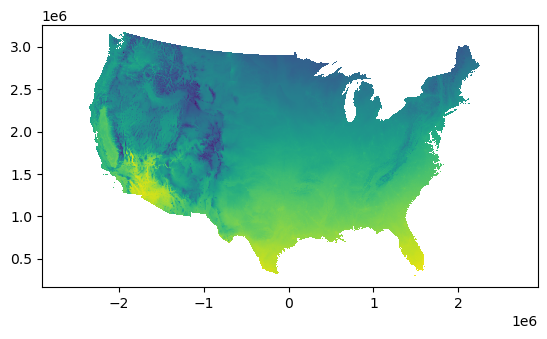

In [90]:
#And just a real quick check:
########

show(image, transform=src.transform, interpolation="none");

### Get some zonal statistics:

In [97]:
#Get for the whole US:
##########

zs = zonal_stats(state_gdf_5070.dissolve().geometry,
                 image, affine=src.transform, nodata=src.nodata,
                 all_touched=True)

In [98]:
#What did we get?
zs

[{'min': -7.0958333015441895,
  'max': 25.629165649414062,
  'mean': 11.289482981699605,
  'count': 13815275}]

In [99]:
#Let's check the mean in Fahrenheit:
#Recall that this is indeed what we got earlier
zs[0]['mean']*1.8+32

52.32106936705929

In [100]:
#And check the count:
#Compare all_touched = True vs. all_touched = False
zs[0]['count']

13815275

In [101]:
#And do for Arizona:
zs = zonal_stats(state_gdf_5070.loc[state_gdf_5070.STATEFP=='04'].geometry,
                 image, affine=src.transform, nodata=src.nodata,
                 all_touched=False)

In [102]:
zs

[{'min': 1.0708333253860474,
  'max': 24.34583282470703,
  'mean': 15.53721438027612,
  'count': 523467}]

In [103]:
#Also get same mean as before: Yay!
zs[0]['mean']*1.8+32


59.96698588449702

#### Get for all states at once:

In [105]:
#And can get for each state at once, with a single line:
#########

zs = zonal_stats(state_gdf_5070.geometry,
                 image, affine=src.transform, nodata=src.nodata)

In [106]:
#This time we got a list of dictionaries, each corresponding to each geometry
zs

[{'min': -4.9666666984558105,
  'max': 9.470833778381348,
  'mean': 5.102762084746819,
  'count': 449244},
 {'min': 7.933333396911621,
  'max': 14.5,
  'mean': 12.395642176540651,
  'count': 45338},
 {'min': 12.820833206176758,
  'max': 17.879167556762695,
  'mean': 15.763937321447575,
  'count': 244326},
 {'min': 1.9499999284744263,
  'max': 8.345833778381348,
  'mean': 4.900216566531271,
  'count': 324727},
 {'min': 11.533333778381348,
  'max': 13.541666984558105,
  'mean': 12.947156063659452,
  'count': 9056},
 {'min': -1.0750000476837158,
  'max': 18.09166717529297,
  'mean': 11.93709521174779,
  'count': 558471},
 {'min': -2.6416666507720947,
  'max': 18.3125,
  'mean': 8.82775952752796,
  'count': 389949},
 {'min': 6.474999904632568,
  'max': 13.1875,
  'mean': 10.834242377952897,
  'count': 111289},
 {'min': 10.283333778381348,
  'max': 14.620833396911621,
  'mean': 12.486268999534273,
  'count': 377904},
 {'min': 10.370833396911621,
  'max': 20.762500762939453,
  'mean': 17.541

In [107]:
# We can convert to a DataFrame
####

pd.DataFrame(zs)

,min,max,mean,count
0,-4.966667,9.470834,5.102762,449244
1,7.933333,14.500000,12.395642,45338
2,12.820833,17.879168,15.763937,244326
3,1.950000,8.345834,4.900217,324727
4,11.533334,13.541667,12.947156,9056
5,-1.075000,18.091667,11.937095,558471
6,-2.641667,18.312500,8.827760,389949
7,6.475000,13.187500,10.834242,111289
8,10.283334,14.620833,12.486269,377904
9,10.370833,20.762501,17.541243,270047


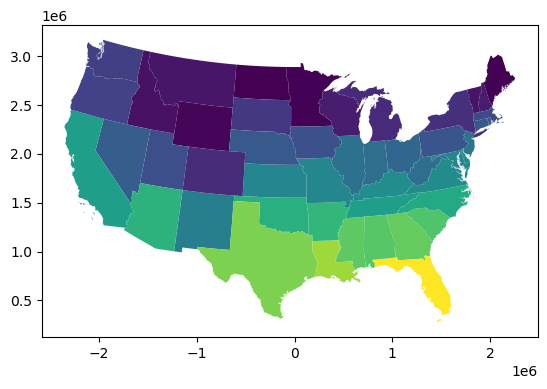

In [110]:
### We generally want to merge the results back in, but we lost our index!
### Never fear, just reset your index and merge, like so:

state_gdf_5070_merged = state_gdf_5070.reset_index().merge(pd.DataFrame(zs), how='left',
                                                           left_index=True, right_index=True)

#And check:
#######
state_gdf_5070_merged.plot(column='mean');

#### Let's save our results so we can use them next time


In [111]:
#### And save:

state_gdf_5070_merged.to_file('CONUS_Temp_Vectors/CONUS_Temp_Vectors.shp')

#### Additional statistics

Defaults:

- `min`
- `max`
- `mean`
- `count`


Additional:

- `sum`
- `std`
- `median`
- `majority (most common value)`
- `minority (least common value)`
- `unique`
- `range`
- `nodata`
- `nan`


- `percentile_<q>` (where `q` is a floating point number between 0 and 100)

Pass list of desired stats as `stats` keyword argument

In [112]:
#Example for Arizona, again:
#######

zs = zonal_stats(state_gdf_5070.loc[state_gdf_5070.STATEFP=='04'].geometry,
        image, affine=src.transform, nodata=src.nodata, all_touched=False,
        stats=['min', 'max', 'mean', 'median', 'sum', 'majority', 'minority', 'unique', 'range',
               'nodata', 'nan', 'percentile_80'])

In [113]:
zs

[{'min': 1.0708333253860474,
  'max': 24.34583282470703,
  'mean': 15.53721438027612,
  'sum': 8133219.0,
  'median': 15.204166412353516,
  'majority': 12.125,
  'minority': 1.0708333253860474,
  'unique': 6947,
  'range': 23.274999499320984,
  'percentile_80': 20.883333206176758,
  'nodata': 92.0,
  'nan': 0}]

#### Custom statistic

- Pass dictionary to `add_stats` keyword argument

In [114]:
#Get max yourself:
##########

def my_max(x):
    return np.max(x)

zs = zonal_stats(state_gdf_5070.loc[state_gdf_5070.STATEFP=='04'].geometry,
        image, affine=src.transform, nodata=src.nodata,
        stats=['min', 'max'],
        add_stats = {'MAX':my_max})

In [115]:
zs

[{'min': 1.0708333253860474, 'max': 24.34583282470703, 'MAX': 24.345833}]

## Point Queries in `rasterstats`

- Let's get the temperature in some cities

- Need to reload our city data, from https://simplemaps.com/data/us-cities

In [116]:
#Get the city df:
#Here's where I downloaded it, change to your local path:
city_df = pd.read_csv('uscities.csv')

#Drop zips to make display cleaner
city_df = city_df.drop(columns = ['zips'])

city_df

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18680025,10768.0,shape,False,True,America/New_York,1,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12531334,3267.0,shape,False,True,America/Los_Angeles,1,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8586888,4576.0,shape,False,True,America/Chicago,1,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6076316,4945.0,shape,False,True,America/New_York,1,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5910669,1522.0,shape,False,True,America/Chicago,1,1840019440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30404,Drummond,Drummond,ID,Idaho,16043,Fremont,43.9996,-111.3433,1,16.4,shape,False,True,America/Boise,3,1840018609
30405,Lost Springs,Lost Springs,WY,Wyoming,56009,Converse,42.7652,-104.9255,1,3.2,shape,False,True,America/Denver,3,1840021288
30406,Provo,Provo,SD,South Dakota,46047,Fall River,43.1937,-103.8329,1,3.1,shape,False,False,America/Denver,3,1840035958
30407,Goldcreek,Goldcreek,MT,Montana,30077,Powell,46.5838,-112.9284,1,1.9,shape,False,False,America/Denver,3,1840032724


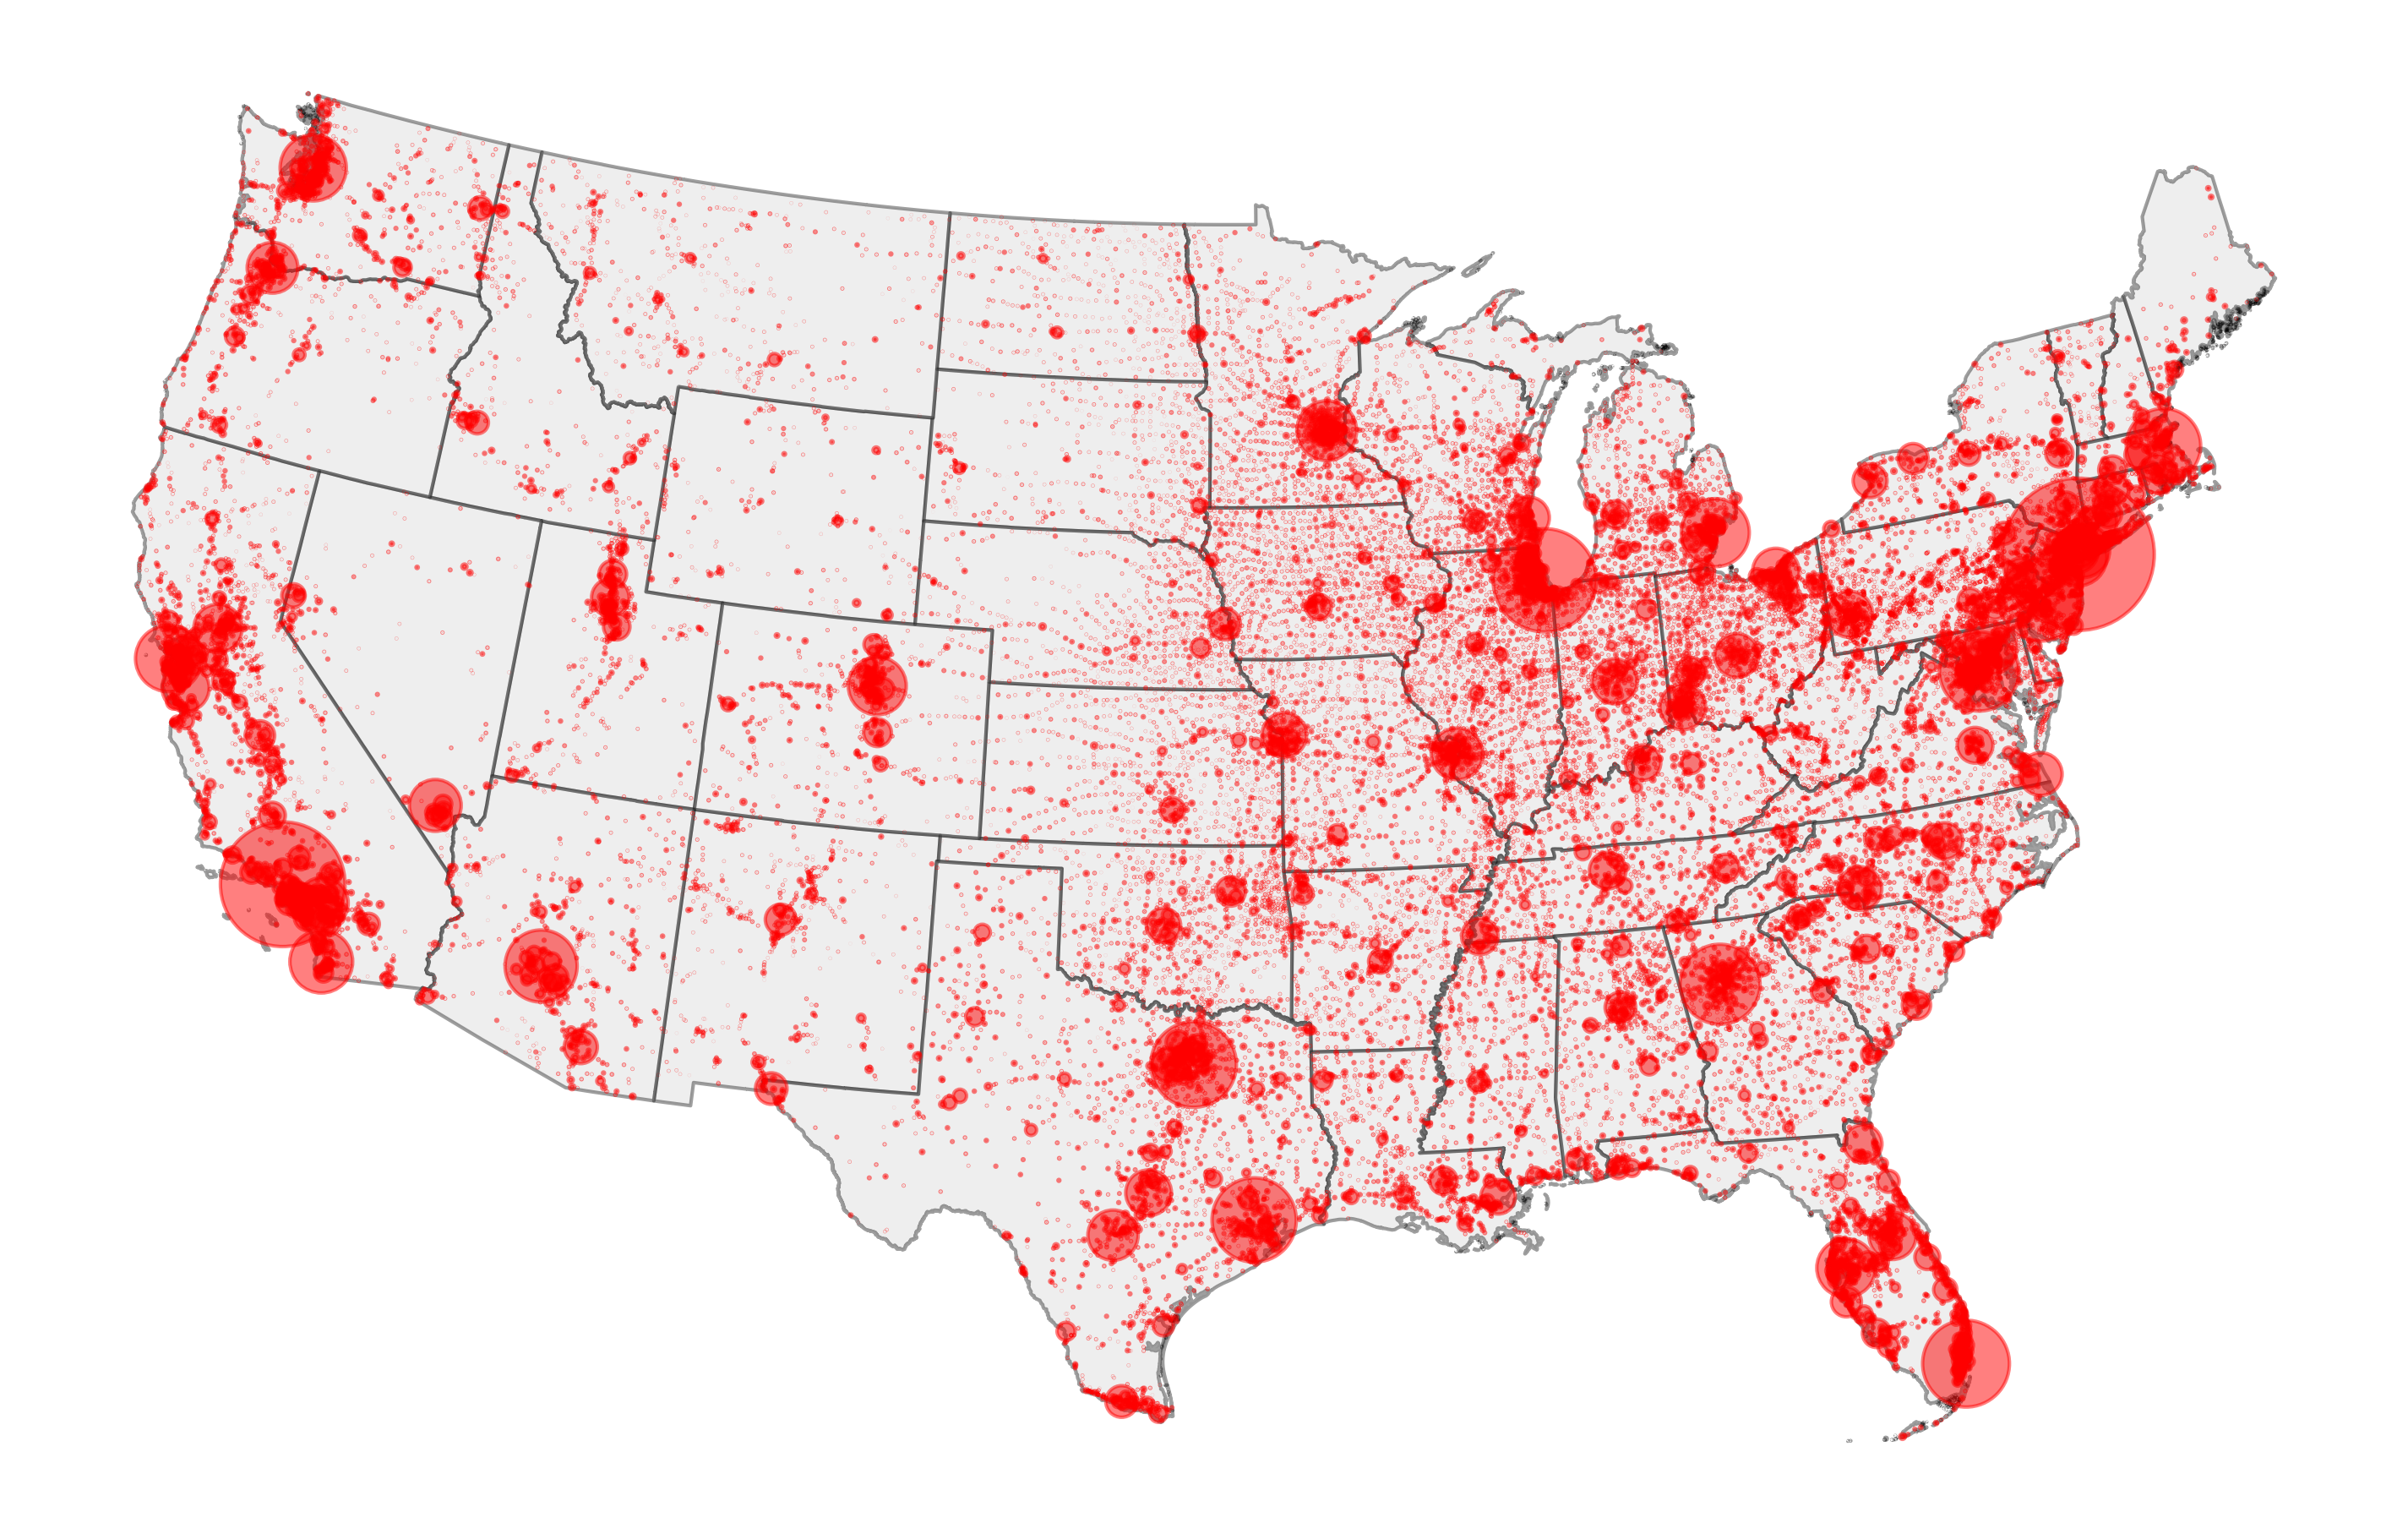

In [117]:
#And put into a GeoDataFrame:
## Can make a GeoDataFrame for better display purposes
###################

#Just keep city name, population, state_id, and lng/lat for now
gdf_city = gpd.GeoDataFrame(city_df[['city', 'population', 'state_id', 'lng', 'lat']], geometry =
                            gpd.points_from_xy(city_df.lng, city_df.lat), crs = "EPSG:4326")

#Also drop anything outside the lower 48:
gdf_city = gdf_city.loc[~gdf_city.state_id.isin(['AK', 'HI', 'PR'])]

#Make an EPSG 5070 version:
gdf_city_5070 = gdf_city.to_crs(5070)


#Plot:
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=300)

#Plot top N cities
N = len(gdf_city_5070)
state_gdf_5070.plot(ax = ax1, facecolor = 'lightgrey', edgecolor='black', alpha=.375)

gdf_city_5070.iloc[:N].plot(ax = ax1, markersize = gdf_city_5070.iloc[:N].population / 1e4, color='red', alpha=.5);

ax1.set_axis_off()


### Now, we use `point_query()`

- Get temperature for 15 most populous cities

In [118]:
#interpolate = nearest or bilinear
###########

pts = point_query(gdf_city_5070.head(15).geometry, image, affine=src.transform, interpolate = 'nearest', nodata=src.nodata)

In [119]:
#We got:
pts

[12.233333587646484,
 16.962499618530273,
 10.25,
 24.558332443237305,
 19.079166412353516,
 20.90833282470703,
 12.754166603088379,
 16.45833396911621,
 13.787500381469727,
 10.199999809265137,
 22.34166717529297,
 9.995833396911621,
 14.029167175292969,
 10.904166221618652,
 18.004167556762695]

In [121]:
#Note that nans are included due to poor resolution of raster if using 10 minute res file

#And what were these values in Fahrenheit
np.array(pts)*1.8+32

array([54.02000046, 62.53249931, 50.45      , 76.2049984 , 66.34249954,
       69.63499908, 54.95749989, 61.62500114, 56.81750069, 50.35999966,
       72.21500092, 49.99250011, 57.25250092, 51.6274992 , 64.4075016 ])

In [122]:
#Merge back into gdf_city_5070? Can just do:
######

gdf_city_5070['point_temp'] = 0
gdf_city_5070['point_temp'].iloc[0:15] = pts

In [123]:
gdf_city_5070.head(15)

,city,population,state_id,lng,lat,geometry,point_temp
0,New York,18680025,NY,-73.9249,40.6943,POINT (1833393.862 2178657.112),12.233334
1,Los Angeles,12531334,CA,-118.4068,34.1141,POINT (-2032603.483 1468467.576),16.962500
2,Chicago,8586888,IL,-87.6866,41.8375,POINT (684628.522 2122697.412),10.250000
3,Miami,6076316,FL,-80.2101,25.7840,POINT (1591844.394 436576.078),24.558332
4,Dallas,5910669,TX,-96.7667,32.7935,POINT (-71387.371 1080540.007),19.079166
5,Houston,5724418,TX,-95.3885,29.7860,POINT (59090.926 745823.123),20.908333
6,Philadelphia,5540199,PA,-75.1339,40.0077,POINT (1751402.839 2080890.990),12.754167
7,Atlanta,5151496,GA,-84.4220,33.7628,POINT (1062228.186 1253258.043),16.458334
8,Washington,5066973,DC,-77.0163,38.9047,POINT (1620145.253 1926587.758),13.787500
9,Boston,4465966,MA,-71.0852,42.3188,POINT (2017007.089 2412490.996),10.200000
